In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import MeanIoU

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL

from DataGenerator_OpenCV import DataGenerator
from models_FCN import FCN_8
from models_UNET import Unet
from utilities import dice, iou

## Quantitative/Qualitative Evaluations for FCN-8 and UNET model

In [16]:
# Instance variables
input_shape    = (768, 896, 3)
image_file_ext = r".tif"
image_xml_ext  = r".xml"
masks_file_ext = r".TIF"
test_dir_p     = "datasets-binary/test"

In [3]:
def plot_all(images):
    title = [ "Original Image (RGB)", "Ground Truth Mask", "Predicted Mask" ]
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15,15) )
    i = 0
    
    for y in range(3):
        axes[y].set_title( title[y] )
        axes[y].imshow(images[i], cmap="gray" )
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1
        
    plt.show()

## 1. FCN-8 Model

In [4]:
model = FCN_8( input_shape, pre_trained=True, base=6 )
# model = FCN_8( input_shape, pre_trained=True, base=3 )
# model = FCN_8( input_shape, pre_trained=True, base=5 )

Model: "FCN_8_base_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 896, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768, 896, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 768, 896, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 768, 896, 64) 36928       block1_conv1[0][0]               
_______________________________________________________________________________________

In [5]:
test_img_list = [os.path.join(test_dir_p + "/images", _) for _ in os.listdir(test_dir_p + "/images") if _.endswith(image_file_ext)]
test_mask_list = [os.path.join(test_dir_p + "/masks", _) for _ in os.listdir(test_dir_p + "/masks") if _.endswith(masks_file_ext)]
# print(test_img_list)

# Create pair list
img_mask_pair_list = []
for image_fp, mask_fp in zip( test_img_list, test_mask_list):
    img_mask_pair_list.append( (image_fp, mask_fp) )

testDataGenerator = DataGenerator( [input_shape[0], input_shape[1], input_shape[2]], 
                                    test_img_list, 
                                    test_mask_list,
                                    batch_size=3)

X, y = testDataGenerator.__getitem__(0)
print(X.shape)
print(y.shape)

(3, 768, 896, 3)
(3, 768, 896, 1)


In [6]:
#loss, dice = model.evaluate(testDataGenerator)
loss, acc_metric = model.evaluate(testDataGenerator)
print(model.name)
print("Loss: \x1b[1;31m", round(loss,4), '\x1b[0m', "Dice: \x1b[1;31m", round(acc_metric,4), '\x1b[0m' )    

  ...
    to  
  ['...']
4/4 [==============================] - 4s 979ms/step - loss: 0.4100 - dice: 0.0315
FCN_8_base_6
Loss:  0.41  Dice:  0.0315 


Image ID: ytma49_111303_benign2_ccd.tif
Dice:  0.0418 


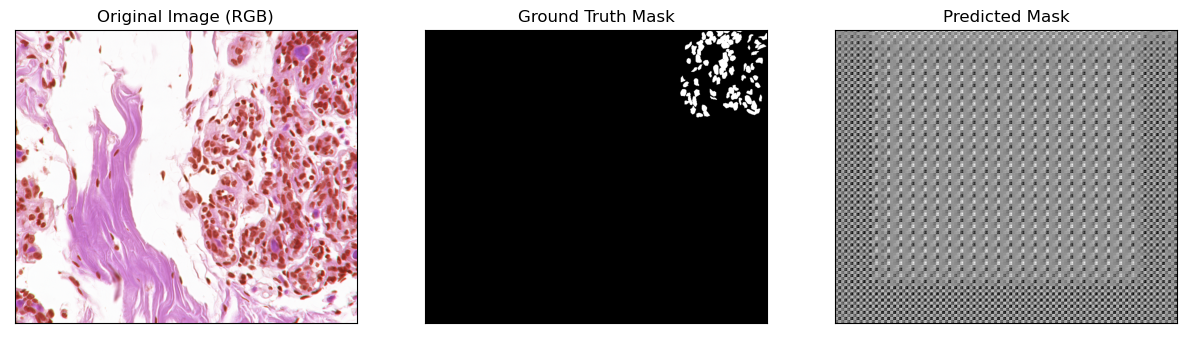

Image ID: ytma49_111303_benign3_ccd.tif
Dice:  0.0368 


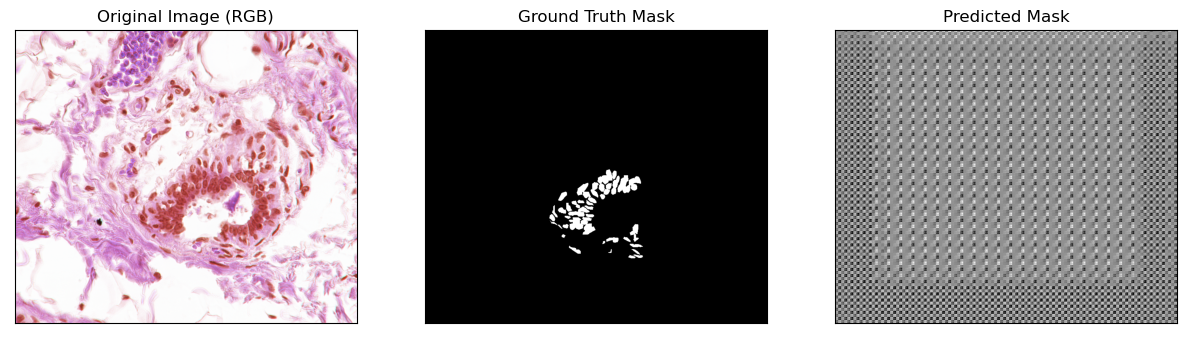

Image ID: ytma49_111303_malignant1_ccd.tif
Dice:  0.0447 


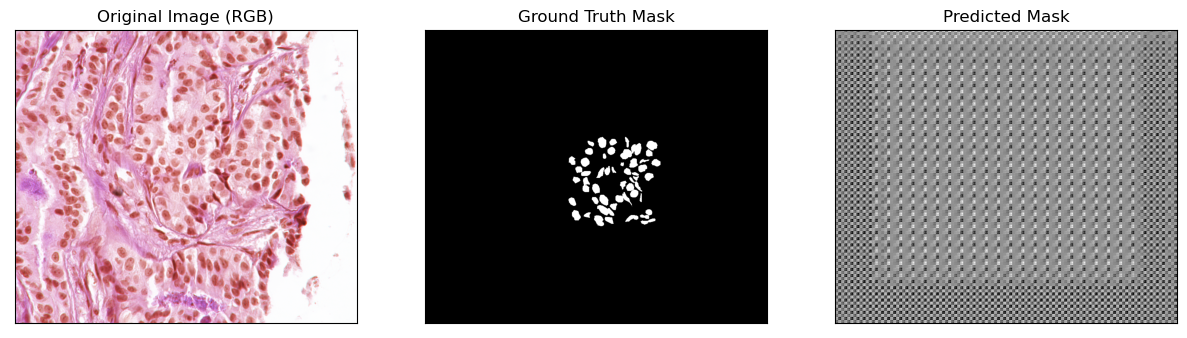

In [7]:
predictions = model.predict(testDataGenerator)

for filename, x, y_true, y_predict in zip(test_img_list, X, y, predictions):
    
    dice_score = dice( y_true, y_predict , smooth=0 )
    
    #m = MeanIoU(num_classes=2)
    #m.update_state(y_true,y_predict)
    
    y_predict = np.squeeze(y_predict) * 255.0
    predicted_mask = np.array(y_predict, dtype=np.uint8)
    
    print("Image ID:",  filename.split("\\",1)[1])
    print( "Dice: \x1b[1;31m", round(dice_score.numpy(),4), '\x1b[0m' )
    # print( "IOU: \x1b[1;31m", round(m.result().numpy()), '\x1b[0m' )
    
    plot_all([ x,
               y_true.squeeze(),
               predicted_mask
              ])   

In [8]:
"""
predictions = model.predict(testDataGenerator)

# print(predictions)
for filename, x, y_true, y_predict in zip(test_img_list, X, y, predictions):
        
   
    img = PIL.ImageOps.autocontrast(array_to_img(y_predict))
    display(img)
"""

'\npredictions = model.predict(testDataGenerator)\n\n# print(predictions)\nfor filename, x, y_true, y_predict in zip(test_img_list, X, y, predictions):\n        \n   \n    img = PIL.ImageOps.autocontrast(array_to_img(y_predict))\n    display(img)\n'

## 2. UNET Model

In [9]:
model = Unet( input_shape, pre_trained=True, base=6 )

Model: "Unet_base_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 768, 896, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768, 896, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 896, 64) 1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 768, 896, 64) 0           conv2d_2[0][0]                   
________________________________________________________________________________________

MODEL RESTORED Unet_base_6


In [10]:
test_img_list = [os.path.join(test_dir_p + "/images", _) for _ in os.listdir(test_dir_p + "/images") if _.endswith(image_file_ext)]
test_mask_list = [os.path.join(test_dir_p + "/masks", _) for _ in os.listdir(test_dir_p + "/masks") if _.endswith(masks_file_ext)]
# print(test_img_list)

# Create pair list
img_mask_pair_list = []
for image_fp, mask_fp in zip( test_img_list, test_mask_list):
    img_mask_pair_list.append( (image_fp, mask_fp) )

testDataGenerator = DataGenerator( [input_shape[0], input_shape[1], input_shape[2]], 
                                    test_img_list, 
                                    test_mask_list,
                                    batch_size=2)

X, y = testDataGenerator.__getitem__(0)
print(X.shape)
print(y.shape)

(2, 768, 896, 3)
(2, 768, 896, 1)


In [11]:
loss, dice = model.evaluate(testDataGenerator)
print(model.name)
print("Loss: \x1b[1;31m", round(loss,4), '\x1b[0m', "Dice\x1b[1;31m", round(dice,4), '\x1b[0m' )   

  ...
    to  
  ['...']
6/6 [==============================] - 6s 953ms/step - loss: 0.4109 - dice: 0.0303
Unet_base_6
Loss:  0.4109  Dice 0.0303 


Image ID: ytma49_111303_benign2_ccd.tif
IOU:  0.1965 


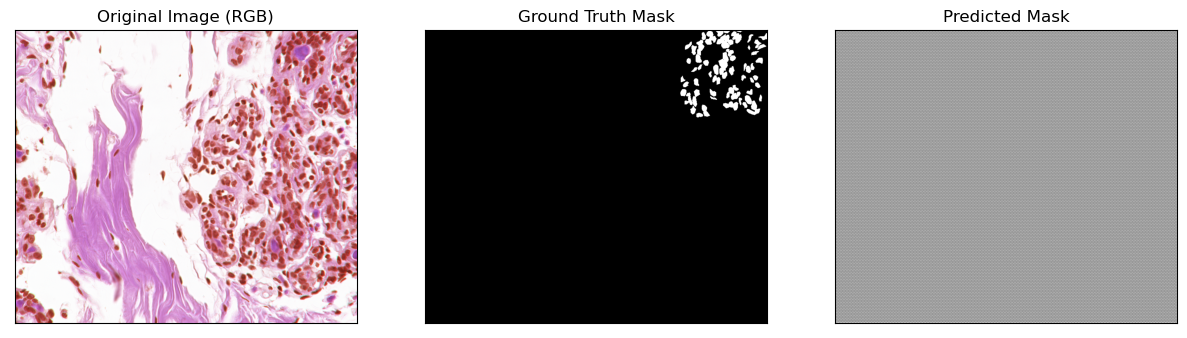

Image ID: ytma49_111303_benign3_ccd.tif
IOU:  0.1949 


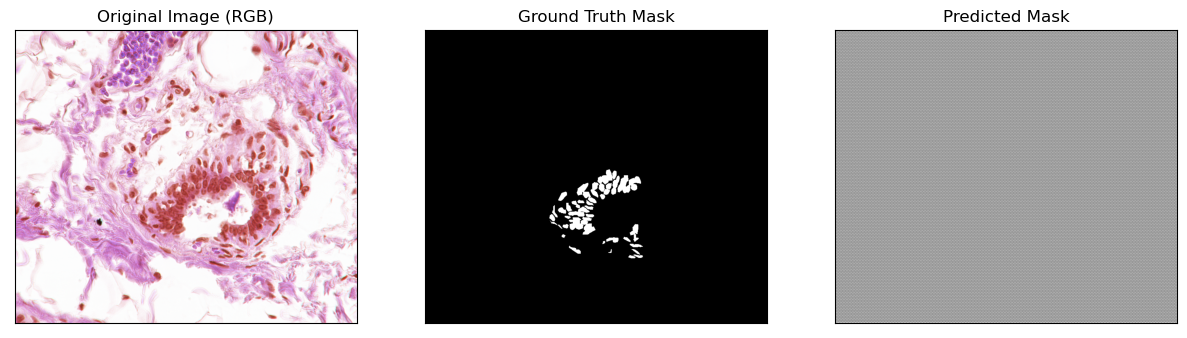

In [15]:
predictions = model.predict(testDataGenerator)

for filename, x, y_true, y_predict in zip(test_img_list, X, y, predictions):
    
    # dice_score = dice( y_true.astype(np.uint8), y_predict.astype(np.uint8), smooth=0 )
    
    m = MeanIoU(num_classes=2)
    m.update_state(y_true,y_predict)
    
    y_predict = y_predict.squeeze()
    predicted_mask = np.array(y_predict, dtype=np.uint8)
        
    print("Image ID:",  filename.split("\\",1)[1])
    print( "IOU: \x1b[1;31m", round(m.result().numpy(),4), '\x1b[0m' )
    print( "Dice: \x1b[1;31m", round(dice_score.numpy(),4), '\x1b[0m' )
    
    plot_all([ x,
               y_true.squeeze(),
               predicted_mask
              ])   